In [3]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv

--2024-10-07 14:28:55--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 298573 (292K) [text/plain]
Saving to: ‘laptops.csv’

laptops.csv         100%[===================>] 291.58K  --.-KB/s    in 0.04s   

2024-10-07 14:28:56 (6.43 MB/s) - ‘laptops.csv’ saved [298573/298573]



In [125]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [145]:
df = pd.read_csv('laptops.csv')

In [146]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [157]:
# Select only storage, ram, screen, and final_price
columns = ['storage', 'ram', 'screen', 'final_price']
df = df[columns]

<Axes: xlabel='final_price', ylabel='Count'>

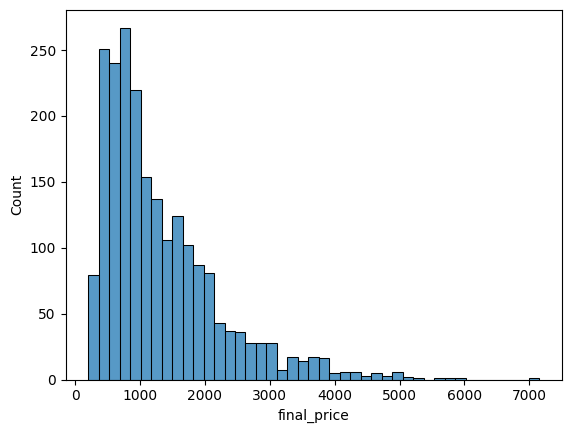

In [158]:
sns.histplot(df.final_price)
# EDA: It has a long tail

<Axes: xlabel='final_price', ylabel='Count'>

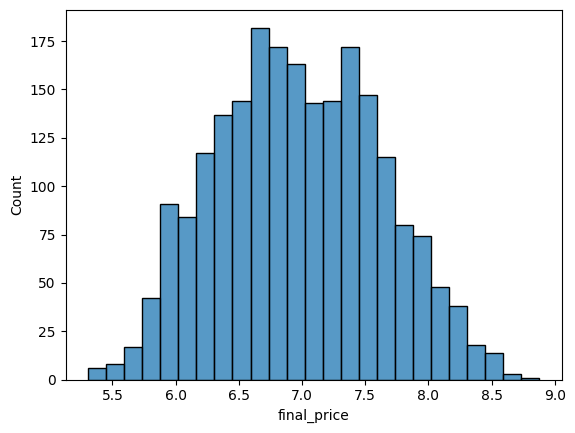

In [159]:
sns.histplot(np.log1p(df.final_price))
# EDA: now it looks more a normal distribution

In [160]:
'''
Question 1
There's one column with missing values. What is it?
'''
df.isnull().sum()

,0
storage,0
ram,0
screen,4
final_price,0


In [161]:
'''
Question 2
What's the median (50% percentile) for variable "ram"?
'''
df.ram.describe()

,ram
count,2160.000000
mean,15.413889
std,9.867815
min,4.000000
25%,8.000000
50%,16.000000
75%,16.000000
max,128.000000


In [162]:
# Prepare and split the dataset
n = len(df)
n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test
print(n_train, n_val, n_test)

1296 432 432


In [163]:
np.random.seed(42)
idx = np.arange(n)
np.random.shuffle(idx)

In [182]:
df_train = df.iloc[idx[:n_train]].copy()
df_val = df.iloc[idx[n_train:n_train+n_val]].copy()
df_test = df.iloc[idx[n_train+n_val:]].copy()

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train_org = df_train.final_price.values
y_val_org = df_val.final_price.values
y_test_org = df_test.final_price.values

y_train = np.log1p(df_train.final_price.values)
y_val = np.log1p(df_val.final_price.values)
y_test = np.log1p(df_test.final_price.values)

del df_train['final_price']
del df_val['final_price']
del df_test['final_price']

print(len(df_train), len(df_val), len(df_test))

1296 432 432


In [180]:
'''
Question 3
We need to deal with missing values for the column from Q1.
We have two options: fill it with 0 or with the mean of this variable.
Try both options. For each, train a linear regression model without regularization using the code from the lessons.
For computing the mean, use the training set only!
Use the validation dataset to evaluate the models and compare the RMSE of each option.
Round the RMSE scores to 2 decimal digits using round(score, 2)
Which option gives better RMSE?
'''
def prepare_X(df, fill_value=0):
  df_num = df.fillna(fill_value)
  X = df_num.values
  return X

def train_linear_regression(X, y):
  ones = np.ones(X.shape[0])
  X = np.column_stack([ones, X])
  XTX = X.T @ X
  XTX_inv = np.linalg.inv(XTX)
  W = XTX_inv @ X.T @ y
  return W

def compute_rmse(y_pred, y_org):
  error = y_pred - y_org
  mse = (error ** 2).mean()
  rmse = np.sqrt(mse)
  return rmse

def plot_predictions(y_org, y_pred):
  plt.figure(figsize=(6, 4))

  sns.histplot(y_org, label='target', color='#222222', alpha=0.6, bins=40)
  sns.histplot(y_pred, label='prediction', color='#aaaaaa', alpha=0.8, bins=40)

  plt.legend()

  plt.ylabel('Frequency')
  plt.xlabel('Log(Price + 1)')
  plt.title('Predictions vs actual distribution')

  plt.show()

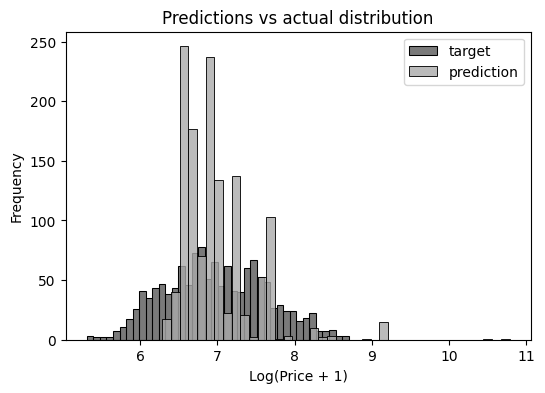

RMSE when filling the NaN values with 0:  0.43


In [172]:
# Option 1: fill with 0
X_train = prepare_X(df_train, fill_value=0)
W = train_linear_regression(X_train, y_train)
y_train_pred = W[0] + X_train @ W[1:]

plot_predictions(y_train, y_train_pred)

X_val = prepare_X(df_val, fill_value=0)
y_val_pred = W[0] + X_val @ W[1:]
rmse = compute_rmse(y_val_pred, y_val)
print('RMSE when filling the NaN values with 0: ', round(rmse, 2))

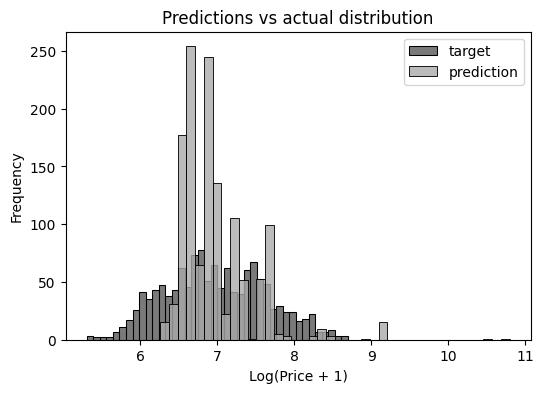

RMSE when filling the NaN values with mean values:  0.43


In [173]:
# Option 2: fill with mean values
means = df_train.mean()
X_train = prepare_X(df_train, fill_value=means)
W = train_linear_regression(X_train, y_train)
y_train_pred = W[0] + X_train @ W[1:]
plot_predictions(y_train, y_train_pred)

X_val = prepare_X(df_val, fill_value=0)
y_val_pred = W[0] + X_val @ W[1:]
rmse = compute_rmse(y_val_pred, y_val)
print('RMSE when filling the NaN values with mean values: ', round(rmse, 2))

In [174]:
'''
Question 4
Now let's train a regularized linear regression.
For this question, fill the NAs with 0.
Try different values of r from this list: [0, 0.01, 0.1, 1, 5, 10, 100].
Use RMSE to evaluate the model on the validation dataset.
Round the RMSE scores to 2 decimal digits.
Which r gives the best RMSE?
If there are multiple options, select the smallest r.

Options:
0
0.01
1
10
100
'''
def train_linear_regression_reg(X, y, r=0.0):
  ones = np.ones(X.shape[0])
  X = np.column_stack([ones, X])
  XTX = X.T @ X
  reg = r * np.eye(XTX.shape[0])
  XTX_inv = np.linalg.inv(XTX + reg)
  W = XTX_inv @ X.T @ y
  return W

regularization_params = [0, 0.01, 0.1, 1, 5, 10, 100]

In [179]:
for r in regularization_params:
  X_train = prepare_X(df_train, fill_value=0)
  W = train_linear_regression_reg(X_train, y_train, r=r)

  X_val = prepare_X(df_val, fill_value=0)
  y_val_pred = W[0] + X_val @ W[1:]
  rmse = compute_rmse(y_val_pred, y_val)

  print(f'RMSE with {r} regularization: {round(rmse, 2)}')

RMSE with 0 regularization: 0.41
RMSE with 0.01 regularization: 0.41
RMSE with 0.1 regularization: 0.41
RMSE with 1 regularization: 0.42
RMSE with 5 regularization: 0.49
RMSE with 10 regularization: 0.57
RMSE with 100 regularization: 0.77


In [187]:
'''
Question 5
We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
Try different seed values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9].
For each seed, do the train/validation/test split with 60%/20%/20% distribution.
Fill the missing values with 0 and train a model without regularization.
For each seed, evaluate the model on the validation dataset and collect the RMSE scores.
What's the standard deviation of all the scores? To compute the standard deviation, use np.std.
Round the result to 3 decimal digits (round(std, 3))
'''
seed_values = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
rmse_results = []

for seed in seed_values:
  np.random.seed(seed)
  idx = np.arange(n)
  np.random.shuffle(idx)

  df_train = df.iloc[idx[:n_train]]
  df_val = df.iloc[idx[n_train:n_train+n_val]]

  df_train = df_train.reset_index(drop=True)
  df_val = df_val.reset_index(drop=True)

  y_train = np.log1p(df_train.final_price.values)
  y_val = np.log1p(df_val.final_price.values)

  y_train_org = df_train.final_price.values
  y_val_org = df_val.final_price.values

  del df_train['final_price']
  del df_val['final_price']

  X_train = prepare_X(df_train, fill_value=0)
  W = train_linear_regression(X_train, y_train_org)

  X_val = prepare_X(df_val, fill_value=0)
  y_val_pred = W[0] + X_val @ W[1:]
  rmse = compute_rmse(y_val_pred, y_val_org)

  rmse_results.append(rmse)
  print(f'RMSE with seed {seed}: {rmse}')

std_rmse = np.std(rmse_results)
print('Standard deviation of all RMSE values: ', round(std_rmse, 3))

RMSE with seed 0: 565.4520868770967
RMSE with seed 1: 636.7985423056728
RMSE with seed 2: 588.9558697907961
RMSE with seed 3: 597.8148920012504
RMSE with seed 4: 571.9627915111031
RMSE with seed 5: 573.2383256618945
RMSE with seed 6: 647.3438328407209
RMSE with seed 7: 550.4398184485949
RMSE with seed 8: 587.33350361699
RMSE with seed 9: 576.1017929433106
Standard deviation of all RMSE values:  29.176


In [188]:
'''
Question 6
Split the dataset like previously, use seed 9.
Combine train and validation datasets.
Fill the missing values with 0 and train a model with r=0.001.
What's the RMSE on the test dataset?
'''
r = 0.001
seed = 9

np.random.seed(seed)
idx = np.arange(n)
np.random.shuffle(idx)

df_train = df.iloc[idx[:n_train+n_val]]
df_test = df.iloc[idx[n_train+n_val:]]

df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = np.log1p(df_train.final_price.values)
y_test = np.log1p(df_test.final_price.values)

y_train_org = df_train.final_price.values
y_test_org = df_test.final_price.values

del df_train['final_price']
del df_test['final_price']

X_train = prepare_X(df_train, fill_value=0)
W = train_linear_regression_reg(X_train, y_train_org, r=r)

X_test = prepare_X(df_test, fill_value=0)
y_test_pred = W[0] + X_test @ W[1:]
rmse = compute_rmse(y_test_pred, y_test_org)

print(f'RMSE with seed {seed}: {rmse}')

RMSE with seed 9: 608.6099822049584
